In [1]:
%matplotlib inline

In [2]:
import os
import re
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mripy.xrfunc.io import load_nii

In [3]:
np.set_printoptions(2)

In [4]:
subject_folder = '/data/projects/swi-ms-coop-graz-dfg/data/subjs_all/gra-0000066695-20180110/'

In [5]:
t1w_path = os.path.join(subject_folder,'mri/msg_t1w/mege_t1w_m.nii.gz')
qsm_path = os.path.join(subject_folder,'qsm/QSMTGV_PDw_E1.nii.gz')
wm_mask_path = os.path.join(subject_folder, 'mri/wmparc_to_mege_t1w.nii.gz')

In [17]:
load_nii(t1w_path,to_ras=True,coords={'echo': np.arange(10,15)})

Dims are not specified. Using ('L', 'P', 'S', 'echo')
spatial dims in coords are ignored


<xarray.DataArray (R: 168, A: 224, S: 192, echo: 5)>
array([[[[ 0., ...,  0.],
         ..., 
         [ 0., ...,  0.]],

        ..., 
        [[ 0., ...,  0.],
         ..., 
         [ 0., ...,  0.]]],


       ..., 
       [[[ 0., ...,  0.],
         ..., 
         [ 0., ...,  0.]],

        ..., 
        [[ 1., ...,  3.],
         ..., 
         [ 1., ...,  7.]]]])
Coordinates:
  * R        (R) int64 167 166 165 164 163 162 161 160 159 158 157 156 155 ...
  * A        (A) int64 223 222 221 220 219 218 217 216 215 214 213 212 211 ...
  * S        (S) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * echo     (echo) int64 10 11 12 13 14
Attributes:
    affine:   [[ -9.99e-01  -2.79e-02  -1.72e-02   8.77e+01]\n [  2.87e-02  -...

In [215]:
qsm = load_nii(qsm_path)

Dims are not specified, default sequence of ('line', 'read', 'slice') is used


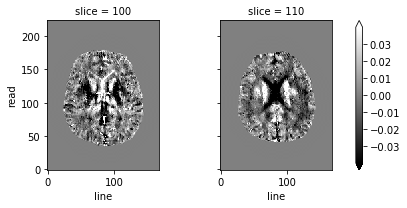

In [218]:
qsm.sel(slice=[100,110]).plot(x='line', y='read', col='slice', robust=True, subplot_kws={'aspect':1}, cmap=plt.cm.gray)

Dims are not specified, default sequence of ('line', 'read', 'slice') is used


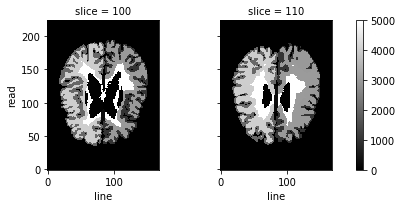

In [221]:
wm_mask = load_nii(wm_mask_filename)
wm_mask.sel(slice=[100,110]).plot(x='line', y='read', col='slice', robust=True, subplot_kws={'aspect':1}, cmap=plt.cm.gray)

In [222]:
import nibabel as nib

In [225]:
sys_wm = nib.aff2axcodes(wm_mask.attrs["affine"])
sys_qsm = nib.aff2axcodes(qsm.attrs["affine"])
print(f'system for WM mask: {sys_wm}')
print(f'system for qsm: {sys_qsm}')

system for WM mask: ('L', 'P', 'S')
system for wsm: ('L', 'A', 'S')


In [229]:
wm_img = nib.load(wm_mask_filename)
wm_img_canonical = nib.as_closest_canonical(wm_img)
print(wm_img.affine)
print(wm_img_canonical.affine)

[[ -9.99e-01  -2.79e-02  -1.72e-02   8.77e+01]
 [  2.87e-02  -9.98e-01  -4.70e-02   1.33e+02]
 [ -1.59e-02  -4.75e-02   9.99e-01  -3.16e+01]
 [  0.00e+00   0.00e+00   0.00e+00   1.00e+00]]
[[  9.99e-01   2.79e-02  -1.72e-02  -8.54e+01]
 [ -2.87e-02   9.98e-01  -4.70e-02  -8.45e+01]
 [  1.59e-02   4.75e-02   9.99e-01  -4.49e+01]
 [  0.00e+00   0.00e+00   0.00e+00   1.00e+00]]


In [234]:
wm = wm_mask.copy()
wm.data = wm_img_canonical.get_data()

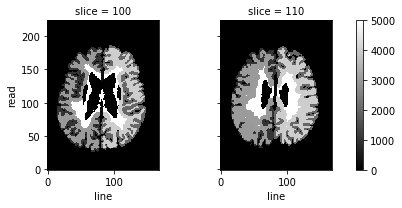

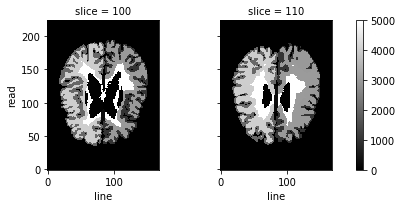

In [235]:
wm.sel(slice=[100,110]).plot(x='line', y='read', col='slice', robust=True, subplot_kws={'aspect':1}, cmap=plt.cm.gray)
wm_mask.sel(slice=[100,110]).plot(x='line', y='read', col='slice', robust=True, subplot_kws={'aspect':1}, cmap=plt.cm.gray)

In [244]:
def load_nii(path, dims=None, coords=None, attrs=None, to_ras=True):
    def map_coords(shape, spatial_dims, flip_map=None):
        spatial_dims = np.array(list(spatial_dims))
        if flip_map is None:
            # id map
            flip_map = dict(zip(spatial_dims, spatial_dims))
        dims_flipped = np.array([flip_map[dim] for dim in spatial_dims])
        dims_to_flip = dims_flipped != spatial_dims

        coords = {dim: np.arange(sz-1,-1,-1) if flip else 
                       np.arange(sz) for dim, flip, sz in zip(dims_flipped, dims_to_flip, shape)}
        return coords

#     import ipdb; ipdb.set_trace()
    img = nib.load(path)
    spatial_dims = nib.aff2axcodes(img.affine)
    
    ndims = len(img.shape)
    if dims is None:
        try:
            dims_default = spatial_dims + ('echo',)
            dims = dims_default[:ndims]
            print(f'Dims are not specified. Using {dims}')
        except IndexError:
            print(f'Cannot infer dims for an {ndims}-dim nifti')
            raise
    else:
        assert ndims == len(dims), f'conflicting sizes: the data are {ndims}-dim but {len(dims)} dims are passed'

    if to_ras:
        flip_to_ras = {'I': 'S', 'L': 'R', 'P': 'A',
                       'S': 'S', 'R': 'R', 'A': 'A'}
        spatial_coords = map_coords(img.shape[:3], spatial_dims, flip_to_ras)
        dims = tuple(spatial_coords.keys()) + dims[3:]
    else:
        spatial_coords = map_coords(img.shape[:3], spatial_dims)

    non_spatial_dims = dims[3:]

    if not coords is None:
        non_spatial_coords = {dim: coords[dim] for dim in non_spatial_dims}
        print('spatial dims in coords are ignored')
    else:
        non_spatial_coords = {dim: np.arange(sz) for dim,sz in zip(dims[3:], img.shape[3:])}

    coords = {**spatial_coords, **non_spatial_coords}    

    da = xr.DataArray(img.get_fdata(),
                      dims=dims,
                      coords=coords)
    da.attrs['affine'] = img.affine
    if attrs is not None:
        da.attrs.update(attrs)

    return da